Combine all data sources

This notebook should contain the first attempt at combining data elements from different tabels in cvr


In [1]:
#import sys
#sys.path.append("/home/svanhmic/workspace/Python/Erhvervs/src/cvr")

sc.addPyFile("/home/svanhmic/workspace/DABAI/ReadData/GetNextJsonLayer.py")
from pyspark import SparkConf
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.window import Window



import os
import GetNextJsonLayer # Custom
from functools import reduce
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from datetime import datetime
import sys

In [2]:
parquetLocation = "/home/svanhmic/workspace/data/DABAI/sparkdata/parquet"
cvrData = "/home/svanhmic/workspace/data/DABAI/sparkdata/json"

In [3]:
#import data
cvrDf = sqlContext.read.json(cvrData+"/AlleDatavirksomheder.json")
cvrDf.printSchema()

root
 |-- virksomhed: struct (nullable = true)
 |    |-- aarsbeskaeftigelse: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- aar: long (nullable = true)
 |    |    |    |-- intervalKodeAntalAarsvaerk: string (nullable = true)
 |    |    |    |-- intervalKodeAntalAnsatte: string (nullable = true)
 |    |    |    |-- intervalKodeAntalInklusivEjere: string (nullable = true)
 |    |    |    |-- sidstOpdateret: string (nullable = true)
 |    |-- attributter: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- sekvensnr: long (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- vaerdier: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- periode: struct (nullable = true)
 |    |    |    |    |    |    |-- gyldigFra: string (nullable = true)
 |    |    |    |    |    |    |-- gyldigTil: string (nulla

In [4]:
areasCols = ["cvrNummer","aarsbeskaeftigelse","virksomhedsstatus","reklamebeskyttet","brancheAnsvarskode","attributter","penheder","hovedbranche","virksomhedsform","maanedsbeskaeftigelse","kvartalsbeskaeftigelse"]
allDataDf = cvrDf.select([F.col("virksomhed."+i) for i in areasCols]).cache()
allDataDf.write.parquet(mode="overwrite",path=parquetLocation+"/virkdata.parquet")
allDataDf.show()
allDataDf.printSchema()

+---------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------------------+
|cvrNummer|  aarsbeskaeftigelse|   virksomhedsstatus|reklamebeskyttet|brancheAnsvarskode|         attributter|            penheder|        hovedbranche|     virksomhedsform|maanedsbeskaeftigelse|kvartalsbeskaeftigelse|
+---------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------------------+
| 27850367|                  []|                  []|           false|              null|                  []|[[1010778499,[200...|[[950000,Private ...|[[T&S,ENK,Enkeltm...|                   []|  [[2004,null,ANTAL...|
| 36376554|                  []|                  []|           false|              null|                  []|[[1020582835,[

In [5]:
secondLayerSchema = GetNextJsonLayer.getNextSchemaLayer(cvrDf.schema,"virksomhed")
#cvrDf.select(cvrDf["virksomhed.attributter.sekvensnr"]).show()
print(secondLayerSchema)

['aarsbeskaeftigelse', 'attributter', 'beliggenhedsadresse', 'bibranche1', 'bibranche2', 'bibranche3', 'binavne', 'brancheAnsvarskode', 'cvrNummer', 'dataAdgang', 'deltagerRelation', 'elektroniskPost', 'enhedsNummer', 'enhedstype', 'fejlBeskrivelse', 'fejlRegistreret', 'fejlVedIndlaesning', 'fusioner', 'hjemmeside', 'hovedbranche', 'kvartalsbeskaeftigelse', 'livsforloeb', 'maanedsbeskaeftigelse', 'naermesteFremtidigeDato', 'navne', 'obligatoriskEmail', 'penheder', 'postadresse', 'regNummer', 'reklamebeskyttet', 'samtId', 'sidstIndlaest', 'sidstOpdateret', 'spaltninger', 'status', 'telefaxNummer', 'telefonNummer', 'virkningsAktoer', 'virksomhedMetadata', 'virksomhedsform', 'virksomhedsstatus']


In [6]:
#CreateAarsbeskaeftigelses data frame
aarsbeskaeftigelseDf = GetNextJsonLayer.createNextLayerTable(allDataDf,["cvrNummer"],"aarsbeskaeftigelse")
#vaekstDf.show()

regexedVaekstDf = (aarsbeskaeftigelseDf
                   .select(aarsbeskaeftigelseDf["cvrNummer"]
                           ,aarsbeskaeftigelseDf["aar"]
                           ,F.split(F.regexp_extract("intervalKodeAntalAarsvaerk",r'(\d{1,4}_\d{1,4})',0),r"\_").alias("intervalKodeAntalAarsvaerk")
                           ,F.split(F.regexp_extract("intervalKodeAntalAnsatte",r'(\d{1,4}_\d{1,4})',0),r"\_").alias("intervalKodeAntalAnsatte")
                           ,F.split(F.regexp_extract("intervalKodeAntalInklusivEjere",r'(\d{1,4}_\d{1,4})',0),r"\_").alias("intervalKodeAntalInklusivEjere")
                           ,aarsbeskaeftigelseDf["sidstOpdateret"])
                   )
#regexedVaekstDf.orderBy(["cvrNummer","aar"]).show()
#regexedVaekstDf.printSchema()

In [7]:
#model the number of aarsværk as a features 15 columns.
windowAarsRank = (Window.partitionBy(F.col("cvrNummer"))
                  .orderBy(F.col("aar").desc()))

aarsDf = (regexedVaekstDf
          .select(regexedVaekstDf["cvrNummer"]
                  ,regexedVaekstDf["aar"]
                  ,regexedVaekstDf["intervalKodeAntalAarsvaerk"][0].cast("double").alias("AarsvaerkLowerBound"))
          .withColumn(colName="rank",col=F.concat(F.lit("AarsVaerk_"),F.rank().over(windowAarsRank)))
          .groupby("cvrNummer")
          .pivot("rank",["AarsVaerk_"+str(i) for i in range(1,16)])
          .sum("AarsvaerkLowerBound")
         )
aarsDf.show()

+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+
|cvrNummer|AarsVaerk_1|AarsVaerk_2|AarsVaerk_3|AarsVaerk_4|AarsVaerk_5|AarsVaerk_6|AarsVaerk_7|AarsVaerk_8|AarsVaerk_9|AarsVaerk_10|AarsVaerk_11|AarsVaerk_12|AarsVaerk_13|AarsVaerk_14|AarsVaerk_15|
+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+
| 10006473|        1.0|        1.0|        1.0|        1.0|        1.0|        1.0|        1.0|        1.0|        1.0|         1.0|         1.0|         2.0|         1.0|         1.0|         2.0|
| 10007372|        0.0|        0.0|        0.0|        1.0|       null|       null|       null|       null|       null|        null|        null|        null|        null|        null|        null|
| 10019052

In [8]:
#take a look at the average number of years a company is open.
allYears = (regexedVaekstDf
            .select(regexedVaekstDf["cvrNummer"],regexedVaekstDf["aar"])
            .groupby("cvrNummer")
            .count()
            .select(F.col("count"))
            .collect())

npAllYears = np.array(list(map(lambda x: x["count"],allYears)))
print(npAllYears[:3])

[1 2 2]


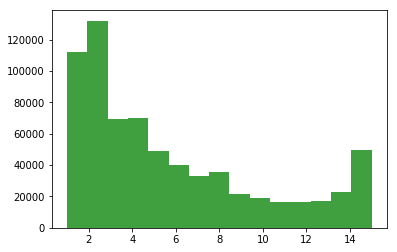

In [9]:
n, bins, patches = plt.hist(npAllYears, 15,  facecolor='green', alpha=0.75)
plt.show()

In [10]:
 #model number of employees plus chief featured over 15 years
medarbejdsDf = (regexedVaekstDf
          .select(regexedVaekstDf["cvrNummer"]
                  ,regexedVaekstDf["aar"]
                   ,regexedVaekstDf["intervalKodeAntalInklusivEjere"][0].cast("double").alias("AntalInklusivEjereLowerBound"))
          .withColumn(colName="rank",col=F.concat(F.lit("medArb_"),F.rank().over(windowAarsRank)))
          .groupby("cvrNummer")
          .pivot("rank",["medArb_"+str(i) for i in range(1,16)])
          .sum("AntalInklusivEjereLowerBound")
         ).cache()
#medarbejdsDf.show()


In [11]:
#Create misc dataframe with cvrnummer, reklamebeskyttelse, virksomhedsstatus
virksomhedsStatusDf = GetNextJsonLayer.createNextLayerTable(allDataDf,["cvrNummer"],"virksomhedsstatus")
exVirksomhedsStatusDf = GetNextJsonLayer.expandSubCols(virksomhedsStatusDf,"periode")
exVirksomhedsStatusDf.cache()
exVirksomhedsStatusDf.show()


+---------+--------------------+--------------------+-----------------+-----------------+
|cvrNummer|      sidstOpdateret|              status|periode_gyldigFra|periode_gyldigTil|
+---------+--------------------+--------------------+-----------------+-----------------+
| 26452635|2015-02-09T21:00:...|              NORMAL|       2002-01-08|       2009-04-20|
| 26452635|2015-02-09T21:00:...|UNDER FRIVILLIG L...|       2009-04-21|       2010-01-20|
| 26452635|2015-02-09T21:00:...|OPLØST EFTER FRIV...|       2010-01-21|       2010-01-21|
| 15157984|2015-02-09T21:00:...|              NORMAL|       1991-05-01|       1993-06-07|
| 15157984|2015-02-09T21:00:...|UNDER TVANGSOPLØS...|       1993-06-08|       1995-09-26|
| 15157984|2015-02-09T21:00:...|        TVANGSOPLØST|       1995-09-27|       1995-09-27|
| 15111038|2015-02-09T21:00:...|              NORMAL|       1991-04-01|       1998-06-29|
| 15111038|2015-02-09T21:00:...| OPLØST EFTER FUSION|       1998-06-30|       1998-06-30|
| 14731644

In [12]:
reklameBeskytDf = GetNextJsonLayer.createNextLayerTable(allDataDf,["cvrNummer","reklamebeskyttet",],"virksomhedsstatus")
reklameBeskytDf = reklameBeskytDf.drop("periode").drop("status").drop("sidstOpdateret")
#reklameBeskytDf.show()

In [13]:
exVirksomhedsStatusDf.select(F.lower(F.col("status")).alias("status")).groupby("status").count().orderBy(F.col("count").desc()).show(truncate=False)

+----------------------------------+------+
|status                            |count |
+----------------------------------+------+
|normal                            |537756|
|under tvangsopløsning             |111725|
|under konkurs                     |75570 |
|opløst efter konkurs              |66524 |
|tvangsopløst                      |59108 |
|under frivillig likvidation       |43242 |
|opløst efter erklæring            |39457 |
|opløst efter frivillig likvidation|37311 |
|opløst efter fusion               |20664 |
|slettet                           |8654  |
|opløst efter spaltning            |6539  |
|uden retsvirkning                 |3198  |
|under reassumering                |637   |
|under rekonstruktion              |322   |
|aktiv                             |9     |
|under reasummering                |7     |
|opløst                            |6     |
|slettes                           |2     |
|opløst efter tvangsopløsning      |1     |
|under reasummation             

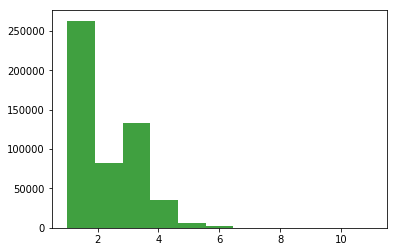

+------------------+
|  avg(statusCount)|
+------------------+
|1.9371181282245886|
+------------------+



In [14]:
statusTransactionDf = exVirksomhedsStatusDf.groupBy("cvrNummer").count()#.orderBy(F.col("count").desc())
#statusTransactionDf.show()
#Show transaction distribution
transactionCol = np.array(list(map(lambda x: float(x[1]),statusTransactionDf.collect())))

n, bins, patches = plt.hist(transactionCol, 11,  facecolor='green', alpha=0.75)
plt.show()

(statusTransactionDf
 .select(F.col("count").alias("statusCount"))
 .groupBy()
 .mean("statusCount")
 .show())

In [15]:
#Determine causes of action for companies
windowRankStatus = (Window
                    .partitionBy(F.col("cvrNummer"))
                    .orderBy(F.col("periode_gyldigFra").desc())
                   )

handlingsForlobDf = (exVirksomhedsStatusDf
                     .withColumn(colName="statusRank",col=F.rank().over(windowRankStatus))
                     .filter(F.col("statusRank") <= 4) 
                     .select(F.col("cvrNummer"),F.col("status"),F.col("statusRank"))
                     .rdd
                     .map(lambda x: (x["cvrNummer"],[(x["status"],x["statusRank"])]))
                     .reduceByKey(lambda x,y: x+y)
                     .map(lambda x: (x[0],[v[0] for v in x[1]],"".join(map(lambda y: y[0]+str(y[1]),x[1]))))
                     .toDF(["cvrNummer","status","statHash"])
                     .select(F.col("cvrNummer"), F.col("status"),F.hash(F.col("statHash")).alias("statusHash"))
                    )
#handlingsForlobDf.show(truncate=False)

In [16]:
#create a list of causes that can be used as labels
def checkLabels(stringVal):

    zeroLabels = ["NORMAL","TVANGSOPLØST","UNDER FRIVILLIG LIKVIDATION","OPLØST EFTER ERKLÆRING","OPLØST EFTER FRIVILLIG LIKVIDATION"
                  ,"OPLØST EFTER FUSION","OPLØST EFTER SPALTNING"]

    oneLabels = ["UNDER KONKURS","OPLØST EFTER KONKURS"]

    miscLabels = ["SLETTET"
                  ,"UNDER RETSVIRKNING"
                  ,"UNDER REASSUMERING"
                  ,"UNDER REKONSTRUKTION"
                  ,"AKTIV"
                  ,"UNDER REASUMMERING"
                  ,"OPLØST"
                  ,"SLETTES"
                  ,"OPLØST EFTER TVANGSOPLØSNING"
                  ,"UNDER REASUMMATION"]   
    
    if stringVal in oneLabels:
        return 1.0
    elif stringVal in zeroLabels:
        return 0.0
    else:
        return 2.0

broadcastedHandlingsForlob = (handlingsForlobDf#.withColumn(col=F.co,colName="label")
                              .drop(F.col("cvrNummer"))
                              .distinct()
                              .rdd
                              .map(lambda x: Row(label=checkLabels(x["status"][0]),statusHash=x["statusHash"]))
                              .toDF(["label","statusHash"])
                                   
                             )
#broadcastedHandlingsForlob.show()

In [17]:
#show the distribution of the causes of action
groupedHandlingerDf = (handlingsForlobDf
                       .groupBy(F.col("statusHash"))
                       .count())
(groupedHandlingerDf
 .join(broadcastedHandlingsForlob,broadcastedHandlingsForlob["statusHash"]==groupedHandlingerDf["statusHash"])
 .drop(groupedHandlingerDf["statusHash"])
 .orderBy(F.col("count").desc())
 #.show(truncate=False)
)

DataFrame[count: bigint, label: double, statusHash: bigint]

In [18]:
#create a list of causes that can be used as labels status' are listed as latest first in the array
labelStatusDf = (handlingsForlobDf
                 .join(broadcastedHandlingsForlob,broadcastedHandlingsForlob["statusHash"]==handlingsForlobDf["statusHash"])
                 .drop(broadcastedHandlingsForlob["statusHash"]).drop(handlingsForlobDf["statusHash"])
                )
#labelStatusDf.show()
#for v in broadcastedHandlingsForlob.take(5):
#    print(v)

In [19]:
#Create attributes  Dataframe
attributesDf = GetNextJsonLayer.createNextLayerTable(allDataDf,["cvrNummer"],"attributter")
#attributesDf.show(10)
#print(attributesDf.schema["cvrNummer"])
#get column names
attributesCols = attributesDf.columns
attributesCols.remove("vaerdier")

attributesWithValueDf = GetNextJsonLayer.createNextLayerTable(attributesDf,attributesCols,"vaerdier")
#attributesWithValueDf.show(10)

attributesWithValueAndPeriodDf = GetNextJsonLayer.expandSubCols(attributesWithValueDf,"periode")
#attributesWithValueAndPeriodDf.show()

valCols = ["cvrNummer","vaerdi","periode_gyldigFra","periode_gyldigTil"]

kapitalFromAttributesDf = (attributesWithValueAndPeriodDf
                           .filter(F.col("type") == "KAPITAL")
                           .select([F.col(x) for x in valCols]+[F.datediff(F.col("periode_gyldigTil"),F.col("periode_gyldigFra")).alias("varighed")])
                          ).cache()
                             
#kapitalFromAttributesDf.orderBy([F.col("cvrNummer"),F.col("gyldigFra")]).show()

In [20]:
formalDF = attributesDf.select("type").groupby("type").count().orderBy(F.col("count").desc())
formalDF.show(40,truncate=False)
formalDF.printSchema

+-------------------------------------------------+------+
|type                                             |count |
+-------------------------------------------------+------+
|NAVN_IDENTITET                                   |730409|
|PSEUDOCVRNR                                      |521736|
|TEGNINGSREGEL                                    |518481|
|FORMÅL                                           |517319|
|REGNSKABSÅR_START                                |514204|
|REGNSKABSÅR_SLUT                                 |514204|
|ARKIV_REGISTRERINGSNUMMER                        |504373|
|VEDTÆGT_SENESTE                                  |500574|
|KAPITAL                                          |499744|
|KAPITALVALUTA                                    |499744|
|FØRSTE_REGNSKABSPERIODE_START                    |488550|
|FØRSTE_REGNSKABSPERIODE_SLUT                     |488549|
|REVISION_FRAVALGT                                |292242|
|EJERREGISTRERING_UNDER_5_PROCENT                 |97265

<bound method DataFrame.printSchema of DataFrame[type: string, count: bigint]>

In [21]:
#Export cvr and names to parque-file
companyAtributDf = attributesWithValueAndPeriodDf.filter(F.col("type") == "NAVN_IDENTITET")
companyAtributDf.write.parquet(mode="overwrite",path=parquetLocation+"/companyCvrData")

In [22]:
#generate x,y dataset
vaerdiListRdd = (kapitalFromAttributesDf
              .select(F.col("cvrNummer"),F.col("vaerdi").cast("double"),F.col("varighed"))
              .rdd
              .map(lambda x: (x["cvrNummer"],([x["vaerdi"]],[x["varighed"]]))))


In [23]:
reduceVaerdiListRdd = (vaerdiListRdd
                       .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))
                       .map(lambda x: (x[0],x[1][0],x[1][1])).toDF(["cvrNummer","vaerdier","varigheder"])
                      )
#reduceVaerdiListRdd.show()

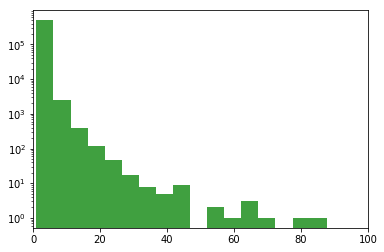

1.39375582852


In [24]:
lenUdf = F.udf(lambda x: len(x),IntegerType())
allNumberOfEntries = reduceVaerdiListRdd.select(F.col("cvrNummer"),lenUdf(F.col("vaerdier")).alias("entries"))

entriesCol = np.array(list(map(lambda x: x[1],allNumberOfEntries.collect())))

n, bins, patches = plt.hist(entriesCol, 30,  facecolor='green', alpha=0.75)
plt.yscale("log")
plt.xlim([0,100])
plt.show()

print(np.mean(entriesCol))

In [25]:
#compute slope e.g. delta = (vaerdi_j - vaerdi_i)/(varighed_j-varighed_i) and get latest 7 slope values

windowSlope = (Window
              .partitionBy(kapitalFromAttributesDf["cvrNummer"])
              .orderBy(kapitalFromAttributesDf["periode_gyldigFra"].asc())
              )
windowSlope.rowsBetween(0,1)

windowRank = (Window
              .partitionBy(kapitalFromAttributesDf["cvrNummer"])
              .orderBy(
                  kapitalFromAttributesDf["periode_gyldigFra"].desc()))
windowRank.rowsBetween(-sys.maxsize,sys.maxsize)

valsCol = ["cvrNummer"]
vaerdiWithSlopeDf = (kapitalFromAttributesDf
                     .withColumn(colName="slope",col=( F.lead("vaerdi").over(windowSlope)-F.col("vaerdi"))/ F.datediff(F.col("periode_gyldigTil"),F.col("periode_gyldigFra")))
                     .withColumn(colName="rank",col=F.rank().over(windowRank))
                     .filter(F.col("rank") <= 8)
                     #.withColumn(colName="inversRank",col=(7-F.col("rank")+1))
                     #.drop(F.col("rank"))
                     #.withColumnRenamed("inversRank","rank")
                     .select(F.col("cvrNummer"),F.col("slope"),F.concat(F.lit("rank_"),F.col("rank")).alias("rank"))
                     .groupby(*valsCol)
                     .pivot("rank",["rank_"+str(i) for i in range(1,9)])
                     .sum("slope")
                     .drop("rank_1")
                     .select(valsCol+[F.col("rank_"+str(i)).alias("rank_"+str(i-1)) for i in range(2,9)])
                    ).cache()

vaerdiWithSlopeDf.show()

+---------+------------------+-----------------+------------------+------+------+------+------+
|cvrNummer|            rank_1|           rank_2|            rank_3|rank_4|rank_5|rank_6|rank_7|
+---------+------------------+-----------------+------------------+------+------+------+------+
| 10017025|              null|             null|              null|  null|  null|  null|  null|
| 10019052|              null|             null|              null|  null|  null|  null|  null|
| 10026113|              null|             null|              null|  null|  null|  null|  null|
| 10027926|              null|             null|              null|  null|  null|  null|  null|
| 10029325| 25906.73575129534|             null|              null|  null|  null|  null|  null|
| 10039983|              null|             null|              null|  null|  null|  null|  null|
| 10040523|1945.5252918287938|              0.0|1160.9907120743035|  null|  null|  null|  null|
| 10056535|              null|          

In [32]:
import numpy as np
np.abs([-1])

array([1])

In [26]:
#Create p-enheder dataframe create count as well

rawpEnhedDf = GetNextJsonLayer.createNextLayerTable(allDataDf,["cvrNummer"],"penheder")
exPEnhedDf = GetNextJsonLayer.expandSubCols(rawpEnhedDf,"periode")
#exPEnhedDf.orderBy("cvrNummer").show()


aggregates = [F.mean,F.sum]
datas = ["aabneEnheder","lukketEnheder","varighed"]
groups = ["cvrNummer"]
exprs = [f(d) for f in aggregates for d in datas]
#print(exprs)
pEnhedDf = (exPEnhedDf.select(F.col("cvrNummer")
                             ,F.col("pNummer"),F.col("periode_gyldigTil"),F.col("periode_gyldigFra")
                             ,F.datediff(F.col("periode_gyldigTil"),F.col("periode_gyldigFra")).alias("varighed")
                             ,F.when(F.isnull(F.col("periode_gyldigTil")),0).otherwise(1).alias("aabneEnheder"),
                             F.when(F.isnull(F.col("periode_gyldigTil")),1).otherwise(0).alias("lukketEnheder"))
            .groupby(*groups)
            .agg(*exprs)
            .drop(F.col("sum(varighed)"))
           ).cache()

pEnhedDf.show()

+---------+-----------------+------------------+------------------+-----------------+------------------+
|cvrNummer|avg(aabneEnheder)|avg(lukketEnheder)|     avg(varighed)|sum(aabneEnheder)|sum(lukketEnheder)|
+---------+-----------------+------------------+------------------+-----------------+------------------+
| 32523048|              1.0|               0.0|             370.0|                2|                 0|
| 32633897|              1.0|               0.0|              91.0|                1|                 0|
| 29870438|              1.0|               0.0|             211.0|                1|                 0|
| 31114136|              1.0|               0.0|             396.0|                1|                 0|
| 78576715|              1.0|               0.0|            5781.0|                1|                 0|
| 33994680|              0.5|               0.5|            1065.0|                1|                 1|
| 27622429|              1.0|               0.0|       

In [27]:
#add virksomhedstype
takeOuts = ["cvrNummer","virksomhedsform"]
fDf = allDataDf.select(*takeOuts)
formDf = GetNextJsonLayer.createNextLayerTable(fDf,takeOuts[:1],takeOuts[1])
formDf = (GetNextJsonLayer
          .expandSubCols(formDf,"periode")
          .withColumn(col=F.unix_timestamp(F.col("periode_gyldigFra"), format='yyyy-MM-dd'),colName="periode_gyldigFra")
          .withColumn(col=F.unix_timestamp(F.col("periode_gyldigTil"), format='yyyy-MM-dd'),colName="periode_gyldigTil")
         )

outputCols = ["cvrNummer","kortBeskrivelse"]
#formDf.show()
##formDf.printSchema()
latestsStatusDf = formDf.groupBy(*outputCols).max("periode_gyldigFra").drop("max(periode_gyldigFra)")
latestsStatusDf.show()

+---------+---------------+
|cvrNummer|kortBeskrivelse|
+---------+---------------+
| 15500387|            APS|
| 31324971|            ENK|
| 36215887|            PMV|
| 32997406|            ENK|
| 16528277|            ENK|
| 21642436|            I/S|
| 27072690|            ENK|
| 19507394|            ENK|
| 25317041|            APS|
| 14252673|            APS|
| 63705314|            ENK|
| 15276991|            A/S|
| 12334508|            APS|
| 11994075|            APS|
| 18642107|            APS|
| 28970331|            APS|
| 13327793|            EFO|
| 25209729|            ENK|
| 28011482|            ENK|
| 30478029|            I/S|
+---------+---------------+
only showing top 20 rows



In [28]:
#combine all sub data frames together. 
compiledDf = (labelStatusDf
              .join(aarsDf,aarsDf["cvrNummer"]==labelStatusDf["cvrNummer"],"inner")
              .drop(aarsDf["cvrNummer"]) #Aarsværker
              .join(medarbejdsDf,labelStatusDf["cvrNummer"]==medarbejdsDf["cvrNummer"],"inner")
              .drop(medarbejdsDf["cvrNummer"]) #Medarbejder
              .join(pEnhedDf,pEnhedDf["cvrNummer"]==labelStatusDf["cvrNummer"],"inner")
              .drop(pEnhedDf["cvrNummer"])#Penheder
              .join(vaerdiWithSlopeDf,vaerdiWithSlopeDf["cvrNummer"]==labelStatusDf["cvrNummer"],"inner")
              .drop(vaerdiWithSlopeDf["cvrNummer"])
              .join(reklameBeskytDf,reklameBeskytDf["cvrNummer"]==labelStatusDf["cvrNummer"],"inner")
              .drop(reklameBeskytDf["cvrNummer"])#reklamebeskyttelse osv.
              .join(latestsStatusDf,latestsStatusDf["cvrNummer"]==labelStatusDf["cvrNummer"],"inner")
              .drop(latestsStatusDf["cvrNummer"])
              .cache() #kapitaler
             )
compiledDf.show()

+---------+--------------------+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+-----------------+------------------+-------------+-----------------+------------------+------------------+------------------+------------------+------+------+------+------+----------------+---------------+
|cvrNummer|              status|label|AarsVaerk_1|AarsVaerk_2|AarsVaerk_3|AarsVaerk_4|AarsVaerk_5|AarsVaerk_6|AarsVaerk_7|AarsVaerk_8|AarsVaerk_9|AarsVaerk_10|AarsVaerk_11|AarsVaerk_12|AarsVaerk_13|AarsVaerk_14|AarsVaerk_15|medArb_1|medArb_2|medArb_3|medArb_4|medArb_5|medArb_6|medArb_7|medArb_8|medArb_9|medArb_10|medArb_11|medArb_12|medArb_13|medArb_14|medArb_15|avg(aabneEnheder)|avg(lukketEnheder)|avg(varighed)|sum(aabneEnh

In [29]:
#rename columns and write to parque-file
renamedCompiledDf = (compiledDf
 .drop("avg(lukketEnheder)")
 .drop("avg(aabneEnheder)")
 .withColumnRenamed(existing="avg(varighed)",new="avgVarighed")
 .withColumnRenamed(existing="sum(aabneEnheder)",new="totalAabneEnheder")
 .withColumnRenamed(existing="sum(lukketEnheder)",new="totalLukketEnheder"))
 
renamedCompiledDf.first()

renamedCompiledDf.write.parquet(mode="overwrite",path=parquetLocation+"/featureDataCvr.parquet")
dateDiff = (datetime(2100,1,1)-datetime(1900,1,1)).days
#print(dateDiff)

In [30]:
filledCols = ["AarsVaerk_1","AarsVaerk_2","AarsVaerk_3","AarsVaerk_4","AarsVaerk_5","AarsVaerk_6","AarsVaerk_7",
              "AarsVaerk_8","AarsVaerk_9","AarsVaerk_10","AarsVaerk_11","AarsVaerk_12","AarsVaerk_13","AarsVaerk_14",
              "AarsVaerk_15","medArb_1","medArb_2","medArb_3","medArb_4","medArb_5","medArb_6","medArb_7","medArb_8",
              "medArb_9","medArb_10","medArb_11","medArb_12","medArb_13","medArb_14","medArb_15","rank_1","rank_2"
              ,"rank_3","rank_4","rank_5","rank_6","rank_7"]

noCvrCols = compiledDf.columns
noCvrCols.remove("cvrNummer")
noCvrCols.remove("status")
noCvrCols.remove("label")
#smallestValueDf = compiledDf.select([F.min(F.col(i)).alias(i) for i in noCvrCols])
#smallestValDict = sc.broadcast(smallestValueDf.collect()[0].asDict()) 
print(smallestValDict.value)

#filledAndShiftedCompiledDf = (compiledDf
#                              .na
#                              .fill(value=0.0,subset=filledCols)
#                              .na
#                              .fill(value=dateDiff,subset=["avg(varighed)"])
#                              .drop("status")
#                              #.select([F.col("cvrNummer"),F.col("label")]+[F.log1p(F.col(i)-F.lit(smallestValDict.value[i])).alias(i) for i in noCvrCols])
#                   )
#filledAndShiftedCompiledDf.show()

NameError: name 'smallestValDict' is not defined